In [14]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import timesync_utils as tutils
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP, combine_dataframes
from dataclasses import dataclass

In [15]:
@dataclass
class training_class:
    csv_file: str
    annot_file: str

@dataclass
class testing_class:
    csv_file: str
    annot_file: str

training_files = {
    "Martin": training_class("../../data/train_data/martin_train_3_030221.csv", 
                            "../../data/annotation/training/martin_train_3_030221.txt"),
    "Simon": training_class("../../data/train_data/simon_train_3_080221.csv",
                            "../../data/annotation/training/simon_train_3_080221.txt"),
    "Jonas": training_class("../../data/train_data/jonas_train_3_080221.csv",
                            "../../data/annotation/training/jonas_train_3_080221.txt")
}

testing_file = testing_class("../../data/test_data/martin_test_3_040221.csv",
                             "../../data/annotation/testing/martin_test_3_040221.txt")

AMOUNT_OF_SENSORS = 3

In [16]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    stamped_poses = get_timestamp_and_pose(training_files[key].annot_file, POSE_MAP)
    elem.align_poses(stamped_poses)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
test_stamped_poses = get_timestamp_and_pose(testing_file.annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  54078
drops: 1254
length of knn_train.df after drops: 52824
52824
Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  52320
drops: 830
length of knn_train.df after drops: 51490
51490
Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  54117
drops: 2098
length of knn_train.df after drops: 52019
52019
Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  4602
drops: 563
length of knn_train.df after drops: 4039
4039


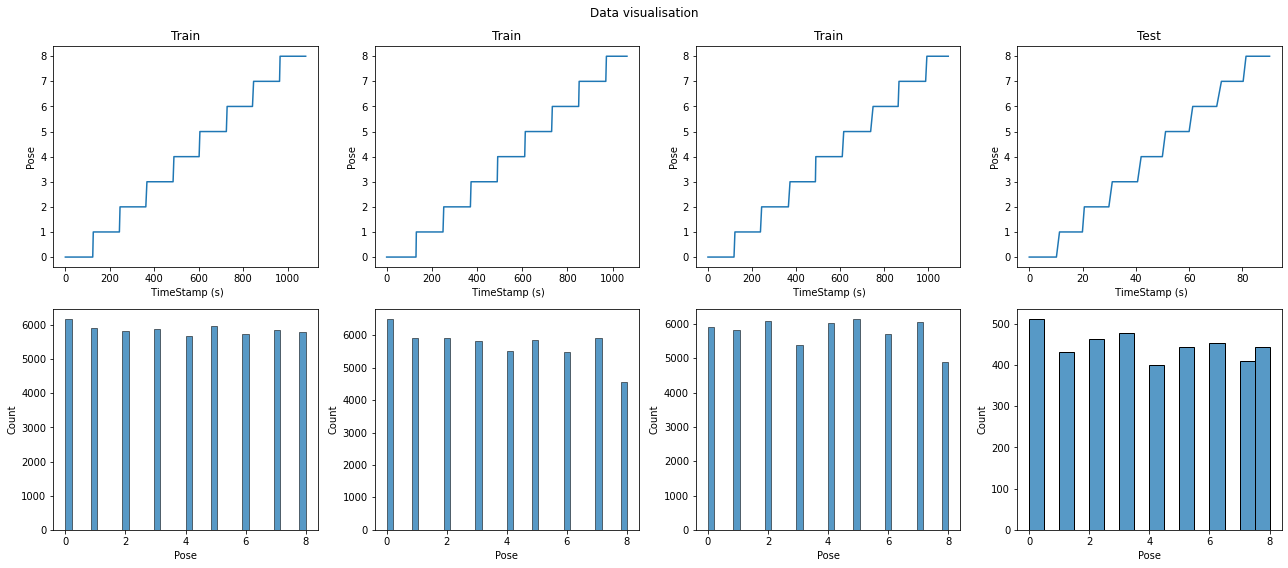

In [17]:
cols = []
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(18, 8))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [18]:
x_train = combine_dataframes([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(156333, 48)
(156333,)
(4039, 48)
(4039,)


### Keras Model

Leger en enkel modell

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

LR = 0.0001
EPOCH = 10
BATCH_SIZE = 1_000
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
#ACTIVATION2 = 'sigmoid'
OPTIM = 'adam'
#OPTIM = 'rmsprop'

def get_compiled_model(input_shape=(AMOUNT_OF_SENSORS*16), output_shape=len(POSE_MAP), lr=LR):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(AMOUNT_OF_SENSORS, activation=ACTIVATION1),
        tf.keras.layers.Dense(int((AMOUNT_OF_SENSORS + output_shape)/2), activation=ACTIVATION1),
        tf.keras.layers.Dense(output_shape, activation=ACTIVATION2)
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
    return model



In [20]:
model = get_compiled_model()
history = model.fit(np.array(x_train), np.array(y_train), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=0)

In [21]:
#y_new = predict_classes(np.array(x_test))
y_new = np.argmax(model.predict(np.array(x_test)), axis=-1)
failed = [i for i in y_test.index if (y_test[i] != y_new[i])]

print(len(failed))
print(len(y_test))

print(f"Precision: {100-(len(failed)/len(y_test))*100}")

3606
4039
Precision: 10.720475365189401


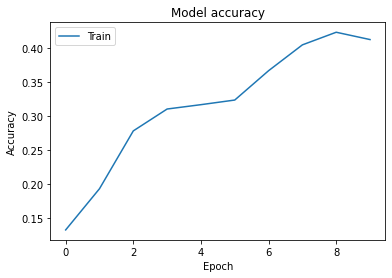

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()